In [1]:
# Initialize the environment
import time, os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Prepare data 
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 15s 3us/step


In [3]:
# Check data
print train_images.shape
print len(train_labels)
print test_images.shape
print len(test_labels)

(60000, 28, 28)
60000
(10000, 28, 28)
10000


In [4]:
#  Preprocess data
#plt.figure()
#plt.imshow(train_images[0])
#plt.colorbar()
#plt.gca().grid(False)

train_images = train_images / 255.0
test_images = test_images / 255.0

In [5]:
# Create an simple model
def createModel(lr,reg):
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(28, 28)),
            keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(reg)),
            keras.layers.Dense(10, activation=tf.nn.softmax, kernel_regularizer=regularizers.l2(reg))
    ])
    model.compile(optimizer=tf.train.AdamOptimizer(lr), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
# Create tool for visualizeing quick scan
def visQuickScan(results):
    import math
    x_scatter = [math.log10(x[0]) for x in results]
    y_scatter = [math.log10(x[1]) for x in results]

    # plot training accuracy
    marker_size = 100
    colors = [results[x][0] for x in results]
    plt.subplot(2, 1, 1)
    plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
    plt.colorbar()
    plt.xlabel('log learning rate')
    plt.ylabel('log regularization')
    plt.title('training accuracy')

    # plot test accuracy
    colors = [results[x][1] for x in results] # default size of markers is 20
    plt.subplot(2, 1, 2)
    plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
    plt.colorbar()
    plt.xlabel('log learning rate')
    plt.ylabel('log regularization')
    plt.title(' test accuracy')
    plt.show()

In [7]:
# Create quick scan loop to find out the entry point
def quickScan(lr_range=[-3.0,-4.0],reg_range=[1,0],epoch=5,batch_size=10,sample=10):
    # init
    results = {}
    learning_rates = lr_range
    regularization_strengths = reg_range
    best_val = -1
    best_lr, best_reg = 0, 0
    
    # Timing
    tic = time.time()
    for i in range(sample):
        lr = 10**np.random.uniform(learning_rates[0],learning_rates[1])
        reg = 10**np.random.uniform(regularization_strengths[0],regularization_strengths[1])
        print 'No.', str(i)
        print 'lr:', str(lr)
        print 'reg:', str(reg)
        
        # model
        model = createModel(lr,reg)
        #model.summary()
        
        # training
        model.fit(train_images, train_labels,
                  validation_data = (test_images,test_labels),
                  epochs=epoch,
                  batch_size=batch_size,
                  shuffle=True)
        
        # evaluate result
        train_loss, train_acc = model.evaluate(train_images, train_labels)
        test_loss, test_acc = model.evaluate(test_images, test_labels)
        print('Train accuracy:', train_acc)
        print('Test accuracy:', test_acc)
        
        # record
        results[(lr,reg)] = (train_acc,test_acc)
        if best_val < test_acc:
            print 'Found Better model!!!'
            best_val = test_acc
            best_lr = lr
            best_reg = reg
            model.save_weights('./weight/myBestweight')
    
    toc = time.time()
    print 'Total Training: computed in %fs' % (toc - tic)
    print 'Best Validation Record %.5f' % (best_val)
    print 'Best Validation learning rate %.10f' % (best_lr)
    print 'Best Validation regularization %.10f' % (best_reg)
    
    # Visaulize the distribution
    visQuickScan(results)
    
    return best_lr, best_reg
  

No. 0
lr: 0.000637619875551
reg: 8.50893416069e-05
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 212us/step - loss: 0.5153 - acc: 0.8252 - val_loss: 0.4617 - val_acc: 0.8468
Epoch 2/5
60000/60000 [==============================] - 13s 222us/step - loss: 0.4092 - acc: 0.8630 - val_loss: 0.4408 - val_acc: 0.8531
Epoch 3/5
60000/60000 [==============================] - 14s 229us/step - loss: 0.3809 - acc: 0.8759 - val_loss: 0.4153 - val_acc: 0.8631
Epoch 4/5
60000/60000 [==============================] - 12s 208us/step - loss: 0.3658 - acc: 0.8814 - val_loss: 0.4253 - val_acc: 0.8610
Epoch 5/5
10000/10000 [==============================] - 0s 25us/step
('Train accuracy:', 0.8946666666666667)
('Test accuracy:', 0.8726)
Found Better model!!!
No. 1
lr: 0.000921987812982
reg: 1.23563684598e-05
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 12s 204us/step - loss: 0.4892 

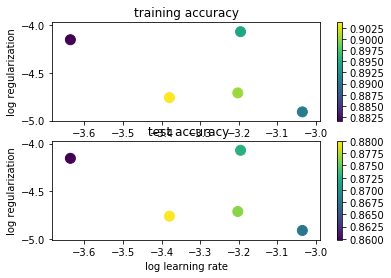

In [8]:
# Create the quick scan loop with the random learning rate & L2
best_lr, best_reg = quickScan(lr_range=[-3.0,-4.0],reg_range=[-4.0,-5.0],epoch=5,batch_size=10,sample=5)

In [9]:
# Use best model to predict label

# load weight
model = createModel(best_lr, best_reg)
model.load_weights('./weight/myBestweight')

train_loss, train_acc = model.evaluate(train_images, train_labels)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

# predict
predictions = model.predict(test_images)
print predictions[0]
print np.argmax(predictions[0])
print test_labels[0]

10000/10000 [==============================] - 0s 25us/step
('Train accuracy:', 0.9037166666666666)
('Test accuracy:', 0.88)
[2.2100805e-06 2.3836930e-07 9.5934388e-07 3.7280817e-05 9.2544933e-06
 8.3902283e-03 4.4102007e-06 3.3667978e-02 6.9169299e-05 9.5781827e-01]
9
9


In [10]:
# Initialize tensorboard
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0,
                          write_graph=True, write_images=False)

In [11]:
# Use the best model to train longer (marathon)
# Load weight, lr, reg
# Add checkpoint & tensorboard metrics

def marathon(lr,reg,epoch,batch_size,tensorboard):
    # Timing
    tic = time.time()
        
    # model
    model = createModel(lr,reg)
    model.load_weights('./weight/myBestweight')
    #model.summary()
        
    # training
    model.fit(train_images, train_labels,
              validation_data = (test_images,test_labels),
              epochs=epoch,
              batch_size=batch_size,
              shuffle=True,
              callbacks=[tensorboard])
        
    # evaluate result
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Train accuracy:', train_acc)
    print('Test accuracy:', test_acc)
        

    model.save_weights('./weight/marathonWeight')
    
    toc = time.time()
    print 'Total Training: computed in %fs' % (toc - tic)

In [ ]:
marathon(best_lr,best_reg,epoch=1000,batch_size=10,tensorboard=tensorboard)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1000
60000/60000 [==============================] - 14s 234us/step - loss: 0.2976 - acc: 0.8951 - val_loss: 0.3535 - val_acc: 0.8767
Epoch 2/1000
60000/60000 [==============================] - 14s 227us/step - loss: 0.2873 - acc: 0.9003 - val_loss: 0.3521 - val_acc: 0.8808
Epoch 3/1000
60000/60000 [==============================] - 14s 227us/step - loss: 0.2770 - acc: 0.9040 - val_loss: 0.3527 - val_acc: 0.8820
Epoch 4/1000
60000/60000 [==============================] - 14s 239us/step - loss: 0.2693 - acc: 0.9075 - val_loss: 0.3539 - val_acc: 0.8819
Epoch 5/1000
60000/60000 [==============================] - 12s 207us/step - loss: 0.2639 - acc: 0.9089 - val_loss: 0.3358 - val_acc: 0.8865
Epoch 6/1000
60000/60000 [==============================] - 14s 226us/step - loss: 0.2566 - acc: 0.9108 - val_loss: 0.3539 - val_acc: 0.8792
Epoch 7/1000
60000/60000 [==============================] - 13s 218us/step - loss: 0.2528 - acc: 0.9146 

60000/60000 [==============================] - 13s 222us/step - loss: 0.1603 - acc: 0.9584 - val_loss: 0.4476 - val_acc: 0.8892
Epoch 59/1000
60000/60000 [==============================] - 13s 219us/step - loss: 0.1589 - acc: 0.9588 - val_loss: 0.4407 - val_acc: 0.8894
Epoch 60/1000
60000/60000 [==============================] - 13s 223us/step - loss: 0.1598 - acc: 0.9582 - val_loss: 0.4664 - val_acc: 0.8858
Epoch 61/1000
60000/60000 [==============================] - 13s 225us/step - loss: 0.1575 - acc: 0.9597 - val_loss: 0.4441 - val_acc: 0.8908
Epoch 62/1000
60000/60000 [==============================] - 15s 243us/step - loss: 0.1587 - acc: 0.9600 - val_loss: 0.4610 - val_acc: 0.8892
Epoch 63/1000
60000/60000 [==============================] - 13s 222us/step - loss: 0.1576 - acc: 0.9598 - val_loss: 0.4546 - val_acc: 0.8872
Epoch 64/1000
60000/60000 [==============================] - 13s 219us/step - loss: 0.1577 - acc: 0.9604 - val_loss: 0.4705 - val_acc: 0.8833
Epoch 65/1000
60000/